## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import torch
from data_load import Normalize, Rescale, CenterCrop
from torchvision import transforms
import cv2
%matplotlib inline

# My key point detector
from models import Net

In [2]:
class PreAndPostProcessing(object):
    # To transform the input and outputs of the key point network
    # into suitable forms.
    def __init__(self, input_size):
        self.wiggle_room = 0.2
        self.input_size = input_size
        self.input_pipeline = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.Resize(self.input_size),
            transforms.CenterCrop(self.input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.],[255.]),
        ])
    
    def preprocess_roi(self, image, rect):
        x,y,w,h = rect
        # Enlarge the roi to ensure that the entire face is captured.
        # (The haar classifier seems to cut off the chin and top of the head)
        d = int(self.wiggle_room * max(w, h))
        x = max(0, x-d)
        y = max(0, y-d)
        w = min(image.shape[1]-x, w+2*d)
        h = min(image.shape[0]-y, h+2*d)
        roi = image[y:y+h, x:x+w]
        preprocessed = self.input_pipeline(roi)
        return preprocessed, (x,y,w,h)
    
    def postprocess_kps(self, kps, rect):
        x,y,w,h = rect
        kps = kps*50. + 100.
        # Now kps contains the points w.r.t the preprocessed image 
        # (i.e. one with size self.input_size)
        # Next I must undo the resizing and cropping.
        if w < h:
            # Cropped in vertical. First undo the scaling.
            # Then offset the coordinate by the amount by which 
            # the image was cropped.
            kps *= w / self.input_size
            kps[:,1] += (h-w) / 2.
        else:
            # Cropped in the horizontal.
            kps *= h / self.input_size
            kps[:,0] += (w-h) / 2.
        kps[:,0] += x
        kps[:,1] += y
        return kps


class KeypointNetwork(object):
    # Wraps the pytorch model
    def __init__(self, model_path):
        net = Net()
        net.load_state_dict(torch.load(model_path))
        net.eval()
        net.cuda()
        self.net = net
        self.input_size = 192
    
    def evaluate(self, image):
        # This takes care of the extra batch index dimension.
        # It also moves data back and forth between gpu and cpu.
        image = image.reshape(1,1,self.input_size, self.input_size)
        with torch.no_grad():
            return self.net(image.cuda()).cpu()[0]


class FaceKeypointDetector(object):
    # The entire detector. Runs the face detector and then on each
    # detected face the key point detector.
    
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
        self.net = KeypointNetwork('saved_models/keypoints_model_4.pt')
        self.processing = PreAndPostProcessing(self.net.input_size)

    def evaluate(self, image):
        kps_of_faces = []
        
        faces = self.face_cascade.detectMultiScale(image, 1.2, 2)
        
        # Filter out very small rectangles. The threshold I set here is 5% of the image dimension.
        # This is done becase the haar classifier generates some false positives which are fairly small areas.
        faces = [*filter(lambda r: r[2]>0.05*image.shape[1] and r[3]>0.05*image.shape[0], faces)]
        
        # loop over the detected faces from your haar cascade
        for (x,y,w,h) in faces:
            preprocessed, rect = self.processing.preprocess_roi(image, (x,y,w,h))
            x, y, w, h = rect

            kps = self.net.evaluate(preprocessed)
            if 0: # Debug
                plt.imshow(preprocessed[0,0])
                plt.scatter(*((kps * 50)+100).T, c='m')
                plt.show()

            kps = self.processing.postprocess_kps(kps, rect)
            kps_of_faces.append(kps)
        
        return faces, kps_of_faces

    
def visualize(image, faces, kps):
    # Plot the image, rectangles and key points
    fig, ax = plt.subplots(1,1, figsize = (10, 10))
    ax.imshow(image)
    for (x,y,w,h), facekps in zip(faces, kps):
        ax.add_artist(matplotlib.patches.Rectangle((x,y), w, h, color='r', fill=False))
        ax.scatter(*facekps.T, c='m')

### Application of the detector

In [3]:
det = FaceKeypointDetector()

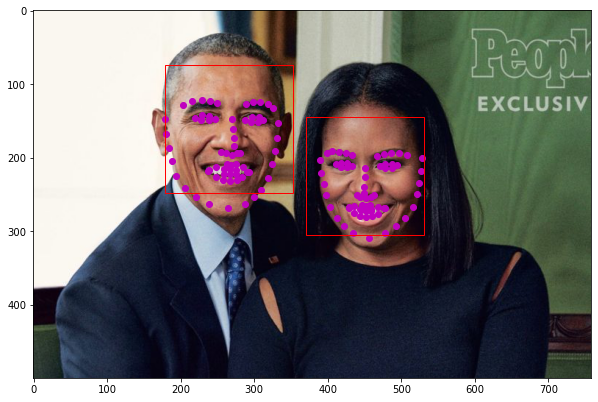

In [4]:
image = cv2.imread('images/obamas.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faces, kps = det.evaluate(image)
visualize(image, faces, kps)

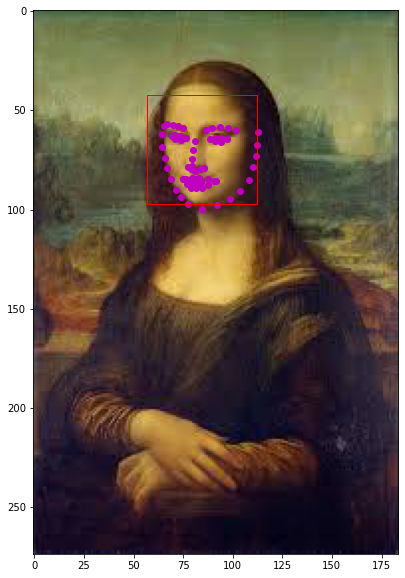

In [5]:
image = cv2.imread('images/mona_lisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faces, kps = det.evaluate(image)
visualize(image, faces, kps)

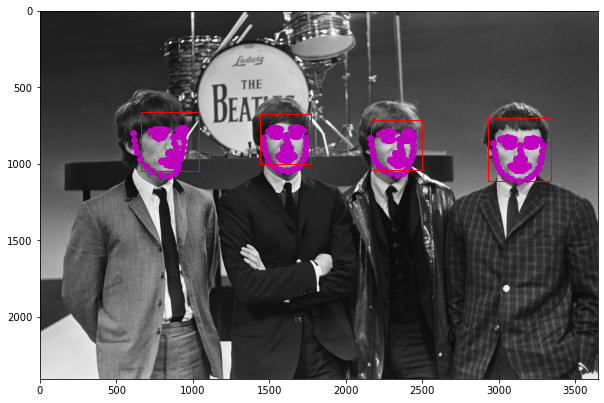

In [6]:
image = cv2.imread('images/the_beatles.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faces, kps = det.evaluate(image)
visualize(image, faces, kps)